<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setting" data-toc-modified-id="Setting-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setting</a></span><ul class="toc-item"><li><span><a href="#Path" data-toc-modified-id="Path-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span><code>Path</code></a></span></li></ul></li><li><span><a href="#SimpleSin-NoNoise-時系列データ作成" data-toc-modified-id="SimpleSin-NoNoise-時系列データ作成-2"><span class="toc-item-num">2&nbsp;&nbsp;</span><code>SimpleSin</code> <code>NoNoise</code> 時系列データ作成</a></span></li><li><span><a href="#入力データ作成" data-toc-modified-id="入力データ作成-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>入力データ作成</a></span></li><li><span><a href="#Model" data-toc-modified-id="Model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span><code>Model</code></a></span><ul class="toc-item"><li><span><a href="#summary" data-toc-modified-id="summary-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>summary</a></span></li><li><span><a href="#Fit" data-toc-modified-id="Fit-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span><code>Fit</code></a></span></li><li><span><a href="#Save-Model" data-toc-modified-id="Save-Model-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Save Model</a></span></li><li><span><a href="#Save-History" data-toc-modified-id="Save-History-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Save History</a></span></li></ul></li><li><span><a href="#history" data-toc-modified-id="history-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>history</a></span></li><li><span><a href="#Predict" data-toc-modified-id="Predict-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Predict</a></span></li></ul></div>

In [1]:
ipynb_title = "create_OnlyConv1dModel__SimpleSinFuncWithNoNoise"

# {{ipynb_title}}

1. データ作成
  - 単なるsin関数を含んだ式
  - ノイズを加える
  - 異常波形作成
1. CNN時系列予測
  - [時系列予測を一次元畳み込みを使って解く with Keras - Qiita
      ](https://qiita.com/niisan-tokyo/items/a94dbd3134219f19cab1)
  - その背景を $windowsize$ 5-60程度で予測するConv1d層の作成

In [2]:
import os,sys
import numpy as np
import matplotlib.pyplot as plt
import datetime
%matplotlib inline
from pathlib import Path

import keras
print("Keras version : ", keras.__version__)

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Keras version :  2.2.2


## Setting

### `Path`

In [3]:
HOME = Path(os.getcwd()).parent
print(HOME)

/home/pollenjp/workdir/git/article_script/20180719_visualize_Conv1d_output__in_kabuku


In [4]:
path_list = []
keras_model_h5_Path = HOME / "keras_model_h5"
path_list.append(keras_model_h5_Path)
data_Path = HOME / "data"
path_list.append(data_Path)
plot_images_Path = data_Path / "plot_images"
path_list.append(plot_images_Path)
fit_hitory_Path = HOME / "fit_history"
path_list.append(fit_hitory_Path)

for _Path in path_list:
    _path = str(_Path)
    if not os.path.exists(_path):
        os.makedirs(name=_path)
        print("make a directory: \n\t", _path)
    else:
        print(os.path.exists(_path), ": ", _path)

True :  /home/pollenjp/workdir/git/article_script/20180719_visualize_Conv1d_output__in_kabuku/keras_model_h5
True :  /home/pollenjp/workdir/git/article_script/20180719_visualize_Conv1d_output__in_kabuku/data
True :  /home/pollenjp/workdir/git/article_script/20180719_visualize_Conv1d_output__in_kabuku/data/plot_images
True :  /home/pollenjp/workdir/git/article_script/20180719_visualize_Conv1d_output__in_kabuku/fit_history


## `SimpleSin` `NoNoise` 時系列データ作成

$$
\textbf{toyfunc(t)} = \sin\left( \frac{2 \pi}{T} t \right)
$$

In [5]:
def mySin(t, period=100):
    """
    時刻t, 周期period
    """
    return np.sin(2.0 * np.pi * t/period)

In [6]:
# Add Noise
def toy_func(tStart=0, tStop=100, tStep=1, noiseAmpl=0):
    """
    T : sin波の周期
    noiseAmpl : ノイズの係数(振幅)
      """
    t = np.arange(start=tStart, stop=tStop, step=tStep)
    noise = np.random.randn(t.shape[0])  # mean=0, standard_deviation=1
    return (t,
            mySin(t, period=100)
            + noiseAmpl * noise )

## 入力データ作成

<img src="images/create_input_data.gif" style="width: 70%; height: 70%">

In [7]:
#----------------------------------------
# Parameters
#----------------------------------------
windowsize = 100  # 周期と同じくとる
predictsize = 1
sample_data_size = 10000
wave_size = sample_data_size
trainsize = int(10000*0.8)

#----------------------------------------
# Sample Wave
#----------------------------------------
t, sample_wave = toy_func(tStop=sample_data_size, noiseAmpl=0)
print(sample_wave.shape)

(10000,)


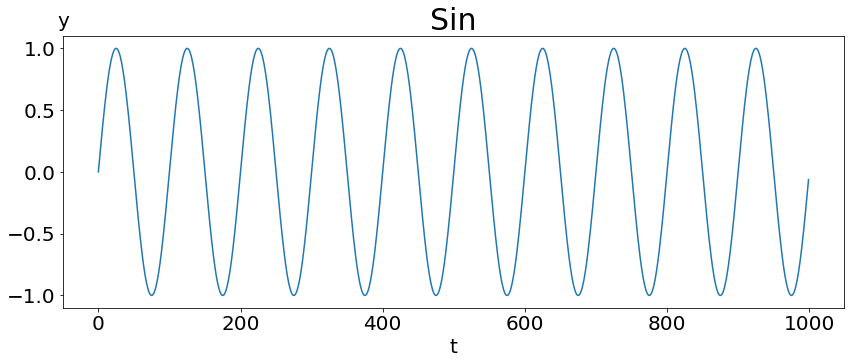

In [8]:
#----------------------------------------
# plot sample wave
#----------------------------------------
filename = ipynb_title + "__wave_with_noise.png"

fig = plt.figure(figsize=(14,5))  # (width, height)
ax = fig.add_subplot(1,1,1)
ax.plot(t[:1000], sample_wave[:1000])

title = "Sin"
ax.set_title(label=title, fontsize=30)
ax.set_xlabel(xlabel="t", fontsize=20)
ax.set_ylabel(ylabel="y", fontsize=20, rotation=0)
ax.yaxis.set_label_coords(x=0.0, y=1.02)
ax.tick_params(labelsize=20)

fig.savefig(fname=str(plot_images_Path / filename))
plt.show()

In [9]:
#----------------------------------------
# create input data
#----------------------------------------
input_data  = np.empty(shape=(0, windowsize))
output_data = np.empty(shape=(0, predictsize))
print(input_data.shape)
print(output_data.shape)
for i in range( sample_wave.shape[0] - (windowsize + predictsize) + 1 ):
    input_data = np.append(arr   =input_data,
                           values=sample_wave[i:(i+windowsize)].reshape(1, -1),
                           axis  =0)
    output_data = np.append(arr   =output_data,
                            values=sample_wave[(i+windowsize):(i+windowsize+predictsize)].reshape(1, -1),
                            axis  =0)
print("input_data.shape  : ", input_data.shape)
print("output_data.shape : ", output_data.shape)
#--------------------
# Kerasのモデルに入力できる形にするためにreshapeして次元を足す
#--------------------
input_data = input_data.reshape((-1, windowsize, 1))
output_data = output_data.reshape((-1, predictsize,))
print("input_data.shape  : ", input_data.shape)
print("output_data.shape : ", output_data.shape)

(0, 100)
(0, 1)
input_data.shape  :  (9900, 100)
output_data.shape :  (9900, 1)
input_data.shape  :  (9900, 100, 1)
output_data.shape :  (9900, 1)


In [12]:
train_x, test_x = input_data[:trainsize], input_data[trainsize:]
train_y, test_y = output_data[:trainsize], output_data[trainsize:]
print("train_x.shape : ", train_x.shape)
print("train_y.shape : ", train_y.shape)
print("test_x.shape  : ", test_x.shape)
print("test_y.shape  : ", test_y.shape)

train_x.shape :  (8000, 100, 1)
train_y.shape :  (8000, 1)
test_x.shape  :  (1900, 100, 1)
test_y.shape  :  (1900, 1)


## `Model`

- Conv1d
  - https://keras.io/ja/layers/convolutional/#conv1d
- [GlobalMaxPooling1D](https://keras.io/layers/pooling/#globalmaxpooling1d)
  

In [13]:
from keras.models import Sequential
from keras.layers.convolutional import Conv1D, UpSampling1D
from keras.layers.pooling import GlobalMaxPooling1D

channel_size = 8
kernel_size = 10

model = Sequential()
model.add( Conv1D(filters=channel_size, kernel_size=kernel_size,
                  strides=1, padding="same", activation="relu",
                  input_shape=(windowsize, 1),
                  ) )
model.add( Conv1D(filters=1,
                  kernel_size=8, padding='same', activation='tanh',
                  ) )
model.add( GlobalMaxPooling1D() )

model.compile(loss='mse', optimizer='adam')

### summary

In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 100, 8)            88        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 100, 1)            65        
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 1)                 0         
Total params: 153
Trainable params: 153
Non-trainable params: 0
_________________________________________________________________


### `Fit`

In [15]:
epochs = 100
from keras.callbacks import EarlyStopping

earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')
callbacks_list = [earlystop]
history = model.fit(x=train_x,
                    y=train_y,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=callbacks_list)

Train on 7200 samples, validate on 800 samples
Epoch 1/100
7200/7200 [==============================] - 2s 221us/step - loss: 0.2387 - val_loss: 0.0740
Epoch 2/100
7200/7200 [==============================] - 0s 42us/step - loss: 0.0453 - val_loss: 0.0323
Epoch 3/100
7200/7200 [==============================] - 0s 41us/step - loss: 0.0263 - val_loss: 0.0204
Epoch 4/100
7200/7200 [==============================] - 0s 41us/step - loss: 0.0157 - val_loss: 0.0121
Epoch 5/100
7200/7200 [==============================] - 0s 42us/step - loss: 0.0101 - val_loss: 0.0084
Epoch 6/100
7200/7200 [==============================] - 0s 41us/step - loss: 0.0074 - val_loss: 0.0064
Epoch 7/100
7200/7200 [==============================] - 0s 42us/step - loss: 0.0058 - val_loss: 0.0053
Epoch 8/100
7200/7200 [==============================] - 0s 42us/step - loss: 0.0048 - val_loss: 0.0044
Epoch 9/100
7200/7200 [==============================] - 0s 42us/step - loss: 0.0040 - val_loss: 0.0037
Epoch 10/100
720

Epoch 75/100
7200/7200 [==============================] - 0s 42us/step - loss: 6.9325e-05 - val_loss: 6.7046e-05
Epoch 76/100
7200/7200 [==============================] - 0s 41us/step - loss: 6.7913e-05 - val_loss: 6.0066e-05
Epoch 77/100
7200/7200 [==============================] - 0s 42us/step - loss: 6.5395e-05 - val_loss: 6.0464e-05
Epoch 78/100
7200/7200 [==============================] - 0s 41us/step - loss: 6.1291e-05 - val_loss: 6.0106e-05
Epoch 79/100
7200/7200 [==============================] - 0s 42us/step - loss: 6.2123e-05 - val_loss: 6.2060e-05
Epoch 80/100
7200/7200 [==============================] - 0s 41us/step - loss: 6.0269e-05 - val_loss: 5.5622e-05
Epoch 81/100
7200/7200 [==============================] - 0s 41us/step - loss: 6.2724e-05 - val_loss: 6.4330e-05
Epoch 82/100
7200/7200 [==============================] - 0s 42us/step - loss: 5.6198e-05 - val_loss: 5.8856e-05
Epoch 83/100
7200/7200 [==============================] - 0s 41us/step - loss: 5.6073e-05 - val_

### Save Model

In [16]:
modelpath = str(keras_model_h5_Path / "model__{}_kernelsize{}.h5".format(ipynb_title, kernel_size))
#if not os.path.exists(modelpath):
model.save(filepath=modelpath, overwrite=True)

### Save History

In [17]:
# error
#import pickle
#
#history_path = str(fit_hitory_Path / ("{}.history.pickle".format(ipynb_title)))
#with open(history_path, "wb") as f:
#    pickle.dump(obj=history, file=f)

## history

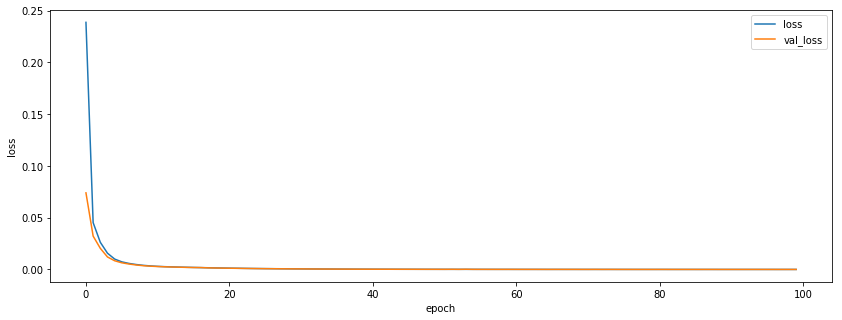

In [18]:
filename = "{}__epochs_loss.png".format(ipynb_title)

fig = plt.figure(figsize=(14, 5))
ax = fig.add_subplot(1,1,1)

ax.plot(history.epoch, history.history['loss'],     label='loss')
ax.plot(history.epoch, history.history['val_loss'], label='val_loss')

ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.legend() 

fig.savefig(fname=str(plot_images_Path / filename))
plt.show()

## Predict

In [19]:
from keras.models import load_model

In [20]:
epochs = 100
kernel_size = 10
modelpath = str(keras_model_h5_Path / "model__{}_kernelsize{}.h5".format(ipynb_title, kernel_size))
model = load_model(filepath=modelpath)

In [21]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 100, 8)            88        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 100, 1)            65        
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 1)                 0         
Total params: 153
Trainable params: 153
Non-trainable params: 0
_________________________________________________________________


-0.00386
(8000, 1)
(8000,)


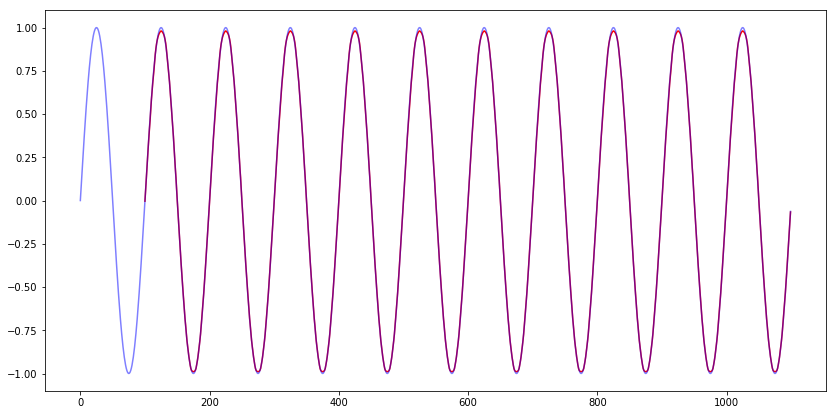

In [22]:
pred = model.predict(train_x)
print(pred.squeeze()[0])
print(pred.shape)
print(pred.squeeze().shape)

time = 1000

fig = plt.figure(figsize=(14,7))
ax = fig.add_subplot(1,1,1)
ax.plot(np.arange(windowsize, wave_size)[:time], pred.squeeze()[:time],
       label="Predict", color="r")
ax.plot(np.arange(0, wave_size)[:time+windowsize], sample_wave.squeeze()[:time+windowsize],
       label="Real", color="b", alpha=0.5)
#ax.plot(np.arange(windowsize, wave_size)[:500], sample_wave[windowsize:][:500])
plt.show()

-0.00386
(8000, 1)
(8000,)


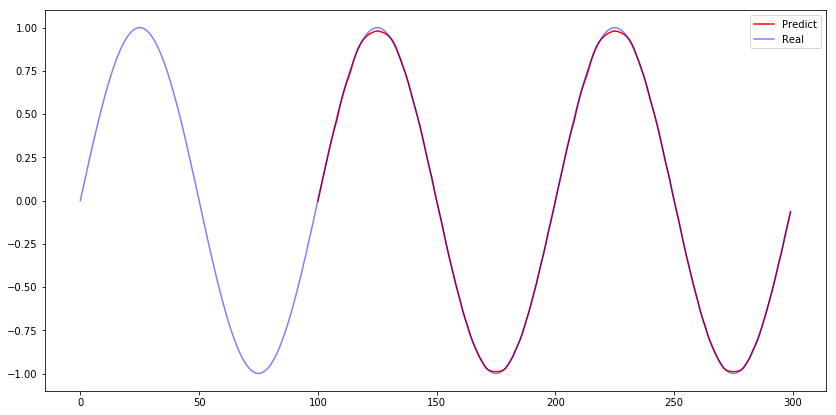

In [23]:
pred = model.predict(train_x)
print(pred.squeeze()[0])
print(pred.shape)
print(pred.squeeze().shape)

time = 200

fig = plt.figure(figsize=(14,7))
ax = fig.add_subplot(1,1,1)
ax.plot(np.arange(windowsize, wave_size)[:time], pred.squeeze()[:time],
       label="Predict", color="r")
ax.plot(np.arange(0, wave_size)[:time+windowsize], sample_wave.squeeze()[:time+windowsize],
       label="Real", color="b", alpha=0.5)
#ax.plot(np.arange(windowsize, wave_size)[:500], sample_wave[windowsize:][:500])
ax.legend()

# End

In [24]:
model.layers[0].kernel_size

(10,)